In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

In this notebook, we run a quick analysis of the pilot walking data, demonstrating our Bayes factor approach. We also simulate the sequential Bayes testing of our two hypotheses and present the rationale behind our feasibility limit of the sample size 

NB: if you want to use the pre-calculated simulation results, you'd need to download the csv files separately from the osf storage, and place it along the notebook files (or just change the file paths in the code)

# Table of contents
* [Pilot data analysis](#pilot)
* [Simulation of Hypothesis 1 SBT](#hyp1)
* [Simulation of Hypothesis 2 SBT](#hyp2)

<a class="anchor" id='pilot'></a>
# Analyzing pilot data


First, let's write some functions which will be used to analyze the pilot data, and later to run SBT simulations of Hypothesis 1

In [2]:
get_pilot_data <- function(){
    " This function reads the pre-processed data. 
    This data file is available at https://osf.io/qn2w6/ along with the raw data and pre-processing scripts"
    filename <- "D:/data/beyond_the_reach/pilot_and _power_analysis/pilot/choices_processed.csv"
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])
    data[, 'choice'] <- factor(data[, 'choice'])
    
    return(data)
}

get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter))
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior)
    }
    return(model)
}

Using these functions, we compose a simple analysis looking at BFs for the pilot data

In [3]:
run_analysis <- function(var, data, rscale){
    " This function runs our analysis for a particular dataset (fake or real) and given DV (var).
    The rscale parameter defines the scale of prior distribution on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (choice | subj_id) + Lambda:choice")),
                     f_choice = as.formula(paste(var, "~ (choice | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    return(bf_result)
}

We fit the models to the data ten times to reduce the noise in BFs (this can take a while, approx. 40 min)

In [ ]:
data <- get_pilot_data()

rt_bfs <- data.frame(bf_10=double(), bf_20=double(), bf_21=double())
max_d_bfs <- data.frame(bf_10=double(), bf_20=double(), bf_21=double())

for (i in 1:10){
    rt_bf <- run_analysis('RT', data, 0.707)
    max_d_bf <- run_analysis('max_d', data, 0.707)
    
    rt_bfs <- rbind(rt_bfs, rt_bf$bf)
    max_d_bfs <- rbind(max_d_bfs, max_d_bf$bf)    
}

colnames(rt_bfs) <- c('bf_10', 'bf_20', 'bf_21')
colnames(max_d_bfs) <- c('bf_10', 'bf_20', 'bf_21')

write.csv(rt_bfs, file = "pilot_fit_results/rt_bfs.csv", row.names=FALSE)
write.csv(max_d_bfs, file = "pilot_fit_results/max_d_bfs.csv", row.names=FALSE)

Let's take a look at the resulting BFs. BF's are coded as bf_10, bf_20, bf_21, where 0 is the null model, 1 is the model with the main effect of choice, and 2 is the full model with the choice-by-lambda interaction

In [10]:
rt_bfs <- read.table("pilot_fit_results/rt_bfs.csv", header = TRUE, sep = ",")
max_d_bfs <- read.table("pilot_fit_results/max_d_bfs.csv", header = TRUE, sep = ",")

In [11]:
colMeans(rt_bfs)
colMeans(max_d_bfs)

bf_10     bf_20     bf_21 
3.6477466 0.9863397 0.2713274

bf_10        bf_20        bf_21 
 15253.48454 323536.87736     21.90146

As for RT model 1 (main effect of choice) seems to be the best, we convert bf_21 to bf_12 for clarity

In [12]:
sprintf('bf_12: %f', 1/colMeans(rt_bfs)[[3]])

[1] "bf_12: 3.685584"

Finally, let's plot the posterior samples using the marginal effects plot from `brms`

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Saving 6.67 x 6.67 in image


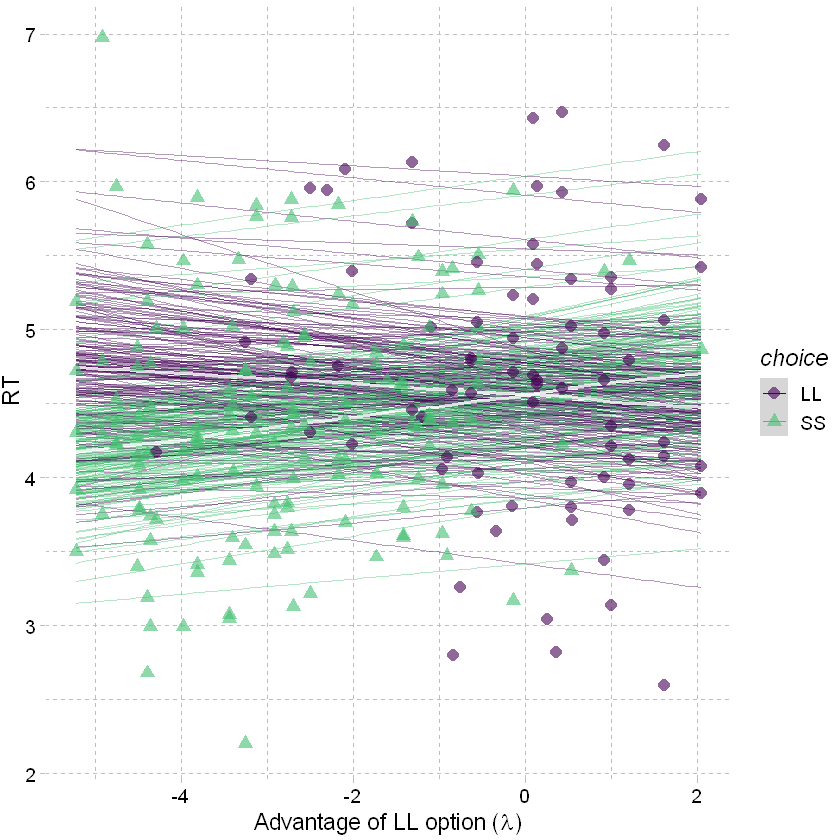

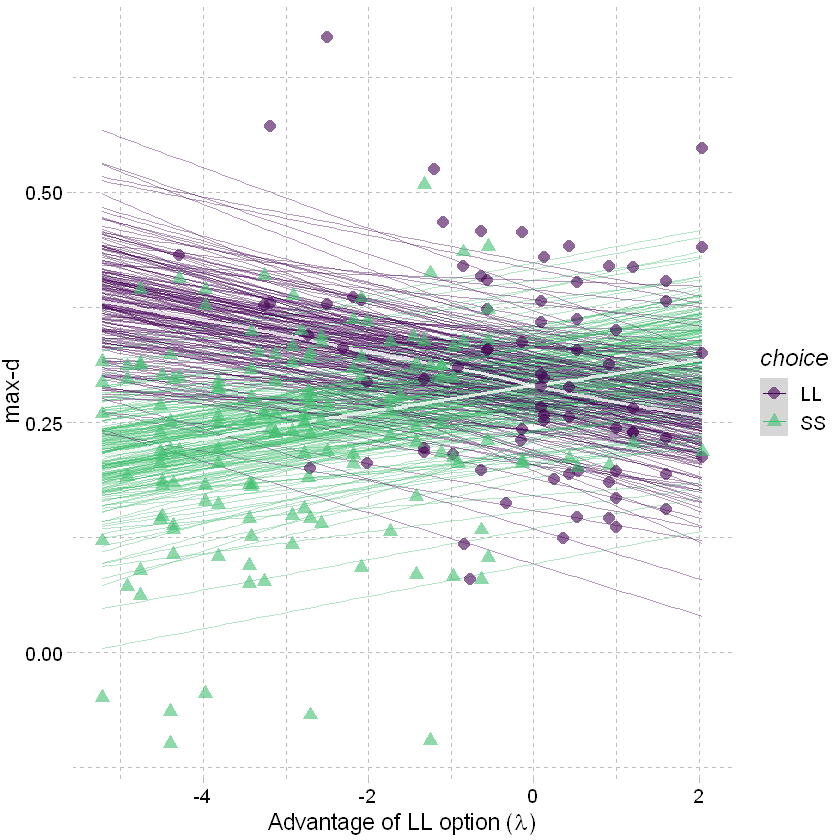

In [13]:
spaghetti <- function(model, var, ylabel){
    plt_dat <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=200), plot=FALSE)
    plt_dat <- plt_dat$"Lambda:choice" + 
        geom_point(aes_string(x="Lambda", y=var, shape='choice', colour='choice'), size = 3, alpha=0.6, data = data) +
        theme_pander(base_size = 14) +
        xlab(TeX('Advantage of LL option ($\\lambda$)')) +
        ylab(ylabel) +
        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)

    plot(plt_dat)
    ggsave(sprintf('figures/spaghetti_%s.png', var), dpi=300)    
}

spaghetti(rt_bf$models$m_inter, 'RT', 'RT')
spaghetti(max_d_bf$models$m_inter, 'max_d', 'max-d')

We also report 95% highest density intervals for the interaction term slope in both interaction models

In [14]:
rt_hpd<-HPDinterval(as.mcmc(rt_bf$models$m_inter, combine_chains = TRUE))
rt_hpd[c('b_Lambda:choiceLL','b_Lambda:choiceSS'),]

,lower,upper
b_Lambda:choiceLL,-0.14636371,0.06418708
b_Lambda:choiceSS,0.01642682,0.13347635


In [15]:
max_d_hpd<-HPDinterval(as.mcmc(max_d_bf$models$m_inter, combine_chains = TRUE))
max_d_hpd[c('b_Lambda:choiceLL','b_Lambda:choiceSS'),]

,lower,upper
b_Lambda:choiceLL,-0.032112833,-0.002021282
b_Lambda:choiceSS,0.004866647,0.023751965


<a class="anchor" id='hyp1'></a>
# Testing Hypothesis 1 (max-d/RT ~ choice x lambda)

Following the spirit of Kruschke (2014) and the tutorial of Vuorre (https://gitlab.com/vuorre/bayesplan), we use the pilot data and three candidate models to generate new values of DV's corresponding to the three scenarios: null effect, main effect of choice, and full model with choice-by-lambda interaction. Then in each scenario, all three models are iteratively fitted to randomly generated datasets, and BF's are computed and stored in the csv files.

Importantly, in testing Hypothesis 1 we do not perform sequential sampling per se, as it turned out that we can confirm/falsify this hypothesis with very high probability based on our lower sample size limit (30 participants)

These code snippets use the functions defined when  [analyzing the pilot data](#pilot)

In [16]:
sim_data_dyn <- function(true_model, pilot_data, var, n_batches, batch_size){
    " First, we create 6 batches of  fake subjects, as if we were running 6 consecutive mini-experiments 
    with 5 subjects in each. In each batch, all but last subject will have 47 trials, and the last one
    will have 42 trials. This is done to match the structure of the pilot dataset, and not fiddle with the
    five trials excluded from the data of one of the subjects. "
    fake_subj_ids <- vector(mode = "numeric", length = 0)
    for (i in 1:n_batches){    
        fake_subj_ids <- c(fake_subj_ids, sort(rep(sample(1001:9999, batch_size, replace = F), 47))[1:nrow(pilot_data)])
    }
    
    " Then, we repeat the pilot data several times changing actual subj_ids to fake subjects along the way "
    fake_data <- rep(pilot_data, n_batches)
    fake_data$subj_id <- fake_subj_ids
        
    " Finally, we replace the DV values in the pilot data by fake values generated by the 'true' model. For 
    example, if our 'true' model is intercept-only, the DV will not have correlate with choice or lambda (on average) "
    fake_var <- predict(true_model, newdata = fake_data, allow_new_levels = T, 
                        sample_new_levels = 'gaussian', subset = 1)
    fake_data[,var] <- fake_var[,1]
    return(fake_data)
}

run_simulation_dyn <- function(var, effect, n_sims){
    # var is either RT or max_d, effect is the hypothetical 'true' effect: one of 'null', 'choice', 'lambda'    
    pilot_data <- get_pilot_data()
    
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(pilot_data[, var]), sd(pilot_data[, var])), class = "Intercept"),
              set_prior(sprintf('cauchy(0, %f)', 0.707*sd(pilot_data[, var])/sd(pilot_data[, 'Lambda'])), class = "b"))
    
    formulas <- list(f_inter = as.formula(paste(var, "~ (choice | subj_id) + Lambda:choice")),
                     f_choice = as.formula(paste(var, "~ (choice | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))
   
    if (effect == 'inter'){
        true_formula <- formulas$f_inter
        true_prior <- prior
    } else if(effect == 'choice'){
        true_formula <- formulas$f_choice
        true_prior <- prior[1,]
    } else if(effect == 'null'){
        true_formula <- formulas$f_null
        true_prior <- prior[1,]
    }
        
    # now, to generate some fake data, we first need to fit the 'true' model to the pilot data
    true_model <- brm(true_formula, data = pilot_data, family = gaussian(), save_all_pars = TRUE,
               control = list(adapt_delta = 0.99), prior = true_prior)
    
    sims <- data.frame(i = integer(), samp_size = integer(), bf_10 = double(), bf_20 = double(), bf_21 = double())
    
    # we're running n_sims independent simulations, in each of them we a) generate fake data based on 'true' model, 
    # and b) fit three candidate models to this fake data and see which performs best based on Bayes factors
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)
        
    for (sim_run in 1:n_sims) {
        n <- n_start
        ns <- n
        
        fake_data <- sim_data_dyn(true_model = true_model, original_data = data, var = var, n_batches = 6, batch_size = 5)
                
        bf_result <- get_bf_dyn(models, fake_data, formulas, prior)
        bfs <- bf_result$bf
        models <- bf_result$models

        idx <- rep(sim_run, length(ns))
        
        sim_result <- as.data.frame(cbind(idx, ns, bfs))

        write.csv(sim_result, file = sprintf("dyn_sim_results/%s_%s_%i.csv", var, effect, sim_run), row.names=FALSE)
        sims <- rbind.data.frame(sims, sim_result)
    }
    names(sims) <- c('idx', 'n', 'bf_10', 'bf_20', 'bf_21')
    write.csv(sims, file = sprintf("dyn_sim_results/%s_%s.csv", var, effect), row.names=FALSE)
}

**Warning**: each call of `run_simulation_dyn` with `n_sims = 100` takes around 6-8 hours on a decent computer, so running the following code snippet requires approx. 40 hours. Its output in csv is available from https://osf.io/qn2w6/ (`dyn_sim_results` directory)

In [ ]:
run_simulation_dyn(var = 'RT', effect = 'null', n_sims = 100)
run_simulation_dyn(var = 'RT', effect = 'choice', n_sims = 100)
run_simulation_dyn(var = 'RT', effect = 'inter', n_sims = 100)

run_simulation_dyn(var = 'max_d', effect = 'null', n_sims = 100)
run_simulation_dyn(var = 'max_d', effect = 'choice', n_sims = 100)
run_simulation_dyn(var = 'max_d', effect = 'inter', n_sims = 100)

Now let's look at the rate of inconclusive test (BF of the best model over the second best is less than 10), the number of cases when the 'true' model was not identified correctly by the procedure (BF of the 'true' model is less than 10), and the mean Bayes factor value of the 'true' model over the second best

In [17]:
describe_bf <- function(outcomes){       
    print(summary(outcomes$target_bf))
    print(sprintf('False detection rate: %.2f', nrow(outcomes[outcomes$target_bf<0.1])/nrow(outcomes)))
    print(sprintf('Inconclusive ratio: %.2f', nrow(outcomes[(outcomes$target_bf>0.1) & (outcomes$target_bf<10)])/nrow(outcomes)))
    print(sprintf('Mean target BF: %.2f', mean(outcomes$target_bf)))
}

# for intercept-only fake data the second best model is the choice model, so we look at 1/bf_10
outcomes <- fread("dyn_sim_results/RT_null.csv")
outcomes$target_bf <- 1/outcomes$bf_10
describe_bf(outcomes)

outcomes <- fread("dyn_sim_results/max_d_null.csv")
outcomes$target_bf <- 1/outcomes$bf_10
describe_bf(outcomes)

# for choice-only fake data the second best model is the interaction model, so we look at 1/bf_21
outcomes <- fread("dyn_sim_results/RT_choice.csv")
outcomes$target_bf <- 1/outcomes$bf_21
describe_bf(outcomes)

outcomes <- fread("dyn_sim_results/max_d_choice.csv")
outcomes$target_bf <- 1/outcomes$bf_21
describe_bf(outcomes)

# for interaction fake data the second best model is the choice model, so we look at 1/bf_21
outcomes <- fread("dyn_sim_results/RT_inter.csv")
outcomes$target_bf <- outcomes$bf_21
describe_bf(outcomes)

outcomes <- fread("dyn_sim_results/max_d_inter.csv")
outcomes$target_bf <- as.double(outcomes$bf_21)
describe_bf(outcomes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.588  39.663  61.741  58.510  75.121 131.093 
[1] "False detection rate: 0.00"
[1] "Inconclusive ratio: 0.04"
[1] "Mean target BF: 58.51"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.344 225.466 352.479 353.811 486.378 725.438 
[1] "False detection rate: 0.00"
[1] "Inconclusive ratio: 0.01"
[1] "Mean target BF: 353.81"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.59  137.38  243.73  250.73  377.21  493.75 
[1] "False detection rate: 0.00"
[1] "Inconclusive ratio: 0.01"
[1] "Mean target BF: 250.73"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.2698  99.0452 211.4247 200.7197 300.9356 430.6694 
[1] "False detection rate: 0.00"
[1] "Inconclusive ratio: 0.05"
[1] "Mean target BF: 200.72"
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.000e+00 1.391e+04 4.115e+05 1.318e+11 2.746e+07 1.050e+13 
[1] "False detection rate: 0.00"
[1] "Inconclusive ratio: 0.01"
[1] "Mean target BF: 131817614717.62"
 

As we see, the false detection rate is exactly zero, and the inconclusive simulations were very rare, ranging from 0 to 5%. Therefore, testing 30 participants will be very likely enough to gather conclusive evidence for or against Hypothesis 1

<a class="anchor" id='hyp2'></a>
# Sequential Bayes testing of Hypothesis 2 (k ~ task)

For Hypothesis 2, we do not have pilot data, so we had to hypothesize the effect size *a priori*. We ran 100 simulations for two scenarios, medium effect (Cohen's $d\approx0.5$) and null effect ($d=0$). We also assumed high correlation between the repeated within-subject measurements of $k$-value ($r=0.7$). O'Hora et al (2016) have previously reported repeated measures of $k$-values within participants in different contexts (e.g., money and food). Analysis of their data reveals a conservative estimate $r=.45$; we estimate that the correlation between repeated measures of monetary discounting will correlate at $r=0.6$ to $0.8$.

In [18]:
sim_data <- function(n, effect, sim_run){
    a <- c(0.02, 0.02)
    b <- c(0.98, 0.98)

    cor = 0.7
    
    "
    NB: k-values in mouse-tracking and walking tasks are randomly generated from bivariate truncated 
    normal distribution, but parameters mu and std of this distribution naturally do not match the 
    expected sample mean and sample sd of each component. There is no simple way of expressing these
    parameters as functions of sample mean and sample sd of each component, so we fine-tuned mu and 
    std to match the values indicated in the comments.
    "
    if (effect) {      
        # means 0.65 vs 0.75 (d=0.5) sd approx 0.2, given cor = 0.7
        mu <- c(1.2, 1.4)
        std = 0.4
        
        # a couple of other possible scenarios
        # means 0.65 vs 0.75 (d=0.5) sd approx 0.2, given cor = 0.6
#         mu <- c(1.2, 1.4)
#         std = 0.4

#         # means 0.67 vs 0.72 (d=0.3) sd approx 0.2, given cor = 0.7
#         mu <- c(1.2, 1.3)
#         std = 0.4

    } else {
        # both means 0.65 (d=0), sd approx 0.2
        mu <- c(.8, .8)
        std = 0.3    
    }    

    sigma <- (std^2)*matrix(c(1, cor, cor, 1), 2, 2)
    X <- rtmvnorm(n=n, mean=mu, sigma=sigma, lower=a, upper=b)
    sim_data <- as.data.frame(X)    
    colnames(sim_data) <- c("m", "w")

    id <- sample.int(10000, nrow(sim_data))
    # the task order is not analyzed here, as we do not expect there to be a main effect or a task by order interaction
    order <- sample(c('wm','mw'), nrow(sim_data), TRUE)

    sim_data <- cbind(subj=as.factor(id), sim_data)
    sim_data <- cbind(order=order, sim_data)
    sim_data <- reshape2::melt(sim_data, id.vars = c("subj", "order"), measure.vars = c("m", "w"))
    colnames(sim_data) <- c("subj", "order", "task", "k")    
    return(sim_data)
}

In [19]:
get_bf_k <- function(data){
    # sd(IV) in this case is 0.5, as IV is task (equal number of 0's and 1's)
    priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data$k), sd(data$k)), class = 'Intercept'),
                    set_prior(sprintf('cauchy(0.0, %f)', 0.707*sd(data$k)/0.5), class = 'b'))

    m_null <- brm(k ~ (1 | subj), data=data, family=gaussian(), save_all_pars=TRUE, prior=priors_task[1,],
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    m_task <- brm(k ~ (1 | subj) + task, data=data, family=gaussian(), save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    bf <- bayes_factor(x1=m_task, x2=m_null)$bf
    names(bf) <- 'bf'
    
    # just in case, we also record the 0.95-highest density interval
    hpd<-HPDinterval(as.mcmc(m_task, combine_chains = TRUE))['b_taskw',]
    
    result = list(bf=t(c(bf, hpd)), m_null=m_null, m_task=m_task)
    
    return(result)
}

get_updated_bf_k <- function(m_null, m_task, new_data){
    m_null <- update(m_null, newdata = new_data, recompile = F)
    m_task <- update(m_task, newdata = new_data, recompile = F)
    bf <- bayes_factor(x1=m_task, x2=m_null)$bf
    names(bf) <- 'bf'
    
    hpd<-HPDinterval(as.mcmc(m_task, combine_chains = TRUE))['b_taskw',]
    result = list(bf=t(c(bf, hpd)), m_null=m_null, m_task=m_task)
    return(result)
}

In [20]:
run_simulation_k <- function(effect, n_sims, n_step){
    n_start <- 30
    n_max <- 300
    bf_crit <- 10
    sims <- data.frame(i=integer(), samp_size=integer(), bfactor=double(), hdi_left=double(), hdi_right=double())

    for (sim_run in 1:n_sims) {
        n <- n_start
        ns <- n
        fake_data <- sim_data(n=n, effect=effect, sim_run=sim_run)

        result <- get_bf_k(data=fake_data)
        bfs <- result$bf
    
        # Additinal subjects are sampled until we exceed 300 subjects or reach the bf boundary
        while ((result$bf[,'bf']<bf_crit) && (result$bf[,'bf']>1/bf_crit) && (n<n_max)) {
            new_batch <- sim_data(n=n_step, effect=effect, sim_run=sim_run)
            fake_data <- rbind(fake_data, new_batch) 

            result <- get_updated_bf_k(m_null = result$m_null, m_task = result$m_task, new_data=fake_data)
            bfs <- rbind(bfs, result$bf)

            n <- n + n_step
            ns <- c(ns, n)
        }

        idx <- rep(sim_run, length(ns))
        result <- as.data.frame(cbind(idx, ns, bfs))

        write.csv(result, file = sprintf("k_sim_results/k_effect_%d_%i.csv", effect, sim_run), row.names=FALSE)
        sims <- rbind.data.frame(sims, result)
    }
    write.csv(sims, file = sprintf("k_sim_results/k_effect_%d_%i.csv", effect, n_sims), row.names=FALSE)
}

**Warning**: each call of `run_simulation` with `n_sims = 100` takes around 5 hours on a decent computer, so the following code snippet requires approx. 10 hours.

One might set `n_step` here to 10 instead of 5 in the proposed SBT procedure to save computation time

In [ ]:
run_simulation_k(effect = TRUE, n_sims = 100, n_step = 5)
run_simulation_k(effect = FALSE, n_sims = 100, n_step = 5)

## Analyzing simulation results

Let's look at the false positive/negative/inconclusive evidence rates at our stopping $n=75$, and also histograms of the stopping $n$ at which BF=10 is reached

In [21]:
plot_hist <- function(terminations, effect){
    p <- ggplot(data=terminations, aes(terminations$n)) + 
        geom_histogram(binwidth=5) +
        xlab('n at termination') +
        ylab('count') +
        scale_x_continuous(breaks = seq(30, 180, by = 10), limits = c(30, 180)) +
        scale_y_continuous(breaks = seq(0, 15, by = 5), limits = c(0, 15)) +    
        theme_hc(base_size = 14)
#     plot(p)
    ggsave(sprintf('figures/sim_k_%s_hist.png', effect), width = 6, height = 3, units = 'in')
}

plot_trace <- function(outcomes, effect){
    p <- ggplot(outcomes, aes(x=ns, y=bf, group=idx)) + 
        geom_line(colour="grey", size=0.8) + 
        xlab('n at termination') +
        ylab('count') +
        scale_x_continuous(name='n', breaks = seq(30, 180, by = 10), limits = c(30, 180)) +
        scale_y_continuous(name = 'BF', breaks = c(0.1, 1, 10, 100), trans='log10', limits = c(0.05, 100)) +
        theme_hc(base_size = 14)
#     plot(p)
    ggsave(sprintf('figures/sim_k_%s_trace.png', effect), width = 6, height = 2, units = 'in')
}

## Medium effect scenario

In [22]:
m = 75
bf_crit = 10

outcomes <- fread("k_sim_results/k_effect_1_100.csv")
terminations <- outcomes[(bf < 1/bf_crit) | (bf > bf_crit)]
terminations <- terminations[, .(first(ns), first(bf)), by = idx]
setnames(terminations, c("idx", "n", "bf"))

sprintf('Average sample number: %.2f', mean(terminations$n))

sprintf('True positive rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf>bf_crit) & (terminations$n < m+1)])/nrow(terminations))
sprintf('Inconclusive evidence ratio at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$n > m+1)])/nrow(terminations))
sprintf('False positive rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf<1/bf_crit) & (terminations$n < m+1)])/nrow(terminations))

plot_trace(outcomes, 'medium')
plot_hist(terminations, 'medium')

[1] "Average sample number: 55.25"

[1] "True positive rate at 75 subjects: 0.82"

[1] "Inconclusive evidence ratio at 75 subjects: 0.17"

[1] "False positive rate at 75 subjects: 0.01"

Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

## Null effect scenario

In [24]:
m = 75
bf_crit = 10

outcomes <- fread("k_sim_results/k_effect_0_100.csv")
terminations <- outcomes[(bf < 1/bf_crit) | (bf > bf_crit)]
terminations <- terminations[, .(first(ns), first(bf)), by = idx]
setnames(terminations, c("idx", "n", "bf"))

sprintf('Average sample number: %.2f', mean(terminations$n))
sprintf('True negative rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf<1/bf_crit) & (terminations$n < m+1)])/nrow(terminations))
sprintf('Inconclusive evidence ratio at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$n > m+1)])/nrow(terminations))
sprintf('False negative rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf>bf_crit) & (terminations$n < m+1)])/nrow(terminations))

plot_hist(terminations, 'null')
plot_trace(outcomes, 'null')

[1] "Average sample number: 60.10"

[1] "True negative rate at 75 subjects: 0.78"

[1] "Inconclusive evidence ratio at 75 subjects: 0.20"

[1] "False negative rate at 75 subjects: 0.02"

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 29 rows containing missing values (geom_path)."

## Sensitivity to $r$

We checked the sensitivity of our results to the correlation between repeated measures $r$. 

In case of medium effect with $r=0.6$, the average sample number required to reach the boundary BF=10 increases from 55 to 72 subjects. However, a lower evidence boundary BF=6 is reached at $m=75$ subjects in 77% of the simulations (although at the expense of increased false negative rate).

In [28]:
m = 75
bf_crit = 6

outcomes <- fread("k_sim_results/cor_0.6/k_effect_1_100.csv")
terminations <- outcomes[(bf < 1/bf_crit) | (bf > bf_crit)]
terminations <- terminations[, .(first(ns), first(bf)), by = idx]
setnames(terminations, c("idx", "n", "bf"))

sprintf('Testing medium effect')

sprintf('Average sample number: %.2f', mean(terminations$n))
sprintf('True positive rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf>bf_crit) & (terminations$n < m+1)])/nrow(terminations))
sprintf('Inconclusive evidence ratio at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$n > m+1)])/nrow(terminations))
sprintf('False negative rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf<1/bf_crit) & (terminations$n < m+1)])/nrow(terminations))

plot_hist(terminations, 'medium_0.6')
plot_trace(outcomes, 'medium_0.6')

[1] "Testing medium effect"

[1] "Average sample number: 55.95"

[1] "True positive rate at 75 subjects: 0.65"

[1] "Inconclusive evidence ratio at 75 subjects: 0.23"

[1] "False negative rate at 75 subjects: 0.12"

Warning message:
"Removed 1 rows containing missing values (geom_bar)."Warning message:
"Removed 10 rows containing missing values (geom_path)."

In case of null effect, however, decreasing r from 0.7 to 0.6 did not significantly hinder the performance of our procedure. ASN increased to 66, but the true negative rate at 75 subjects was still high, 77%.

In [29]:
m = 75
bf_crit = 10

sprintf('Testing null effect')

outcomes <- fread("k_sim_results/cor_0.6/k_effect_0_100.csv")
terminations <- outcomes[(bf < 1/bf_crit) | (bf > bf_crit)]
terminations <- terminations[, .(first(ns), first(bf)), by = idx]
setnames(terminations, c("idx", "n", "bf"))

sprintf('Average sample number: %.2f', mean(terminations$n))
sprintf('True negative rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf<1/bf_crit) & (terminations$n < m+1)])/nrow(terminations))
sprintf('Inconclusive evidence ratio at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$n > m+1)])/nrow(terminations))
sprintf('False negative rate at %i subjects: %.2f', 
        m, nrow(terminations[(terminations$bf>bf_crit) & (terminations$n < m+1)])/nrow(terminations))

plot_hist(terminations, 'null_0.6')
plot_trace(outcomes, 'null_0.6')

[1] "Testing null effect"

[1] "Average sample number: 66.30"

[1] "True negative rate at 75 subjects: 0.77"

[1] "Inconclusive evidence ratio at 75 subjects: 0.22"

[1] "False negative rate at 75 subjects: 0.01"

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."Warning message:
"Removed 17 rows containing missing values (geom_path)."